# 0 Outline
1. Data Process Functions or Class, APIs:
    - can input from excel or others.
    - Output 2-D data points.
        - 1th dimention indicates single data point(x,y,z,t,value).
        - 2th dimention indicates the number of data points.
    - Every data point has form (x,y,z,t,value), where x,y,z is spatial corordinate, t is temporal corordinates, and value is function(to be solved) value.
    - be Tensor.
    - can assign accuracy for each number.
    - can assign whether gradient 'on' or 'off'.

2. Model Functions or Class, APIs:
    - models

3. Tool Functions or Class, APIs:
    - train
    - evaulate

4. Visualization Functions or Class, APIs:


关于数据集的一些信息
pass
可能人为取点
- 线段
- 或cube
- 或圆盘

方程形式：
$$
\begin{aligned}
\begin{cases}
u_t(x,t) &= \triangle u(x,t),\quad t\in(0,T],\quad x\in\Omega \subset \mathbf{R}^n \\
u(x,t) &= 0 ,\quad x\in \partial\Omega\times (0,T] \\
u(x,0) &= \sin(x) \quad x\in\Omega
\end{cases}
\end{aligned}
$$

先考虑$\Omega = [0,\pi]$以及时间为$(0,10]$的情形。
此时上述形式的方程有解析解$u(x,t) = \sin(x)\exp(-t)$

此处test norm(实际上应该是test loss)表达式为：
$$
\mathcal{L}
=
||u_t + P_s u - f||_{L^2({\Omega \times (0,T]})}^2 + ||u(x,t)||_{L^2(\partial\Omega\times (0,T])}^2 +||u(x,0) - u_0(x)||_{H^2(\Omega)}^2
$$

# import modules involved

In [1]:
import torch
import pandas
import torch.nn as nn
import collections
import numpy as np
import matplotlib.pyplot as plt

import itertools

In [2]:
x = [(1,2),(2,3)]
y = [1,2]
list(itertools.product(x, y))

[((1, 2), 1), ((1, 2), 2), ((2, 3), 1), ((2, 3), 2)]

# Data Functions or Classes.

In [3]:
class DataProcess:
    """
    数据读取与预处理
    主要是数据读取
    流程(以Excel为例)
    1.读取Excel表 (需要Pandas包)
    2.把数据转换成Tensor格式
    3.把数据变成指定形状
        - 二维矩阵
        - 行数代表数据点个数
        - 每一行代表一个数据点，(x,y,z,t,value)
    4.其它要求
        - 区分边界点和内部点
        - 区分训练集和验证集
    """
    def __init__(self,input,output,spatial_dimension):
        pass

    def ReadFromExcel(self,filename):
        pass

# Model Functions or Classes
- model

In [4]:
class HeatEqModel(nn.Module):
    """
    - 确定深度模型
    - 前向函数
    - 需要需要确定方程的系数
    """
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        f_boundary,
        f_ini,
        u_real = None,
        act=torch.nn.Tanh
    ):
        super(HeatEqModel, self).__init__()

        self.f_boundary = f_boundary
        self.f_ini = f_ini
        self.u_real = u_real
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.depth = depth
        self.act = act

        layers = [('input', torch.nn.Linear(self.input_size, self.hidden_size))]
        layers.append(('input_activation', self.act()))
        for i in range(self.depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(self.hidden_size, self.hidden_size))
            )
            layers.append(('activation_%d' % i, self.act()))
        layers.append(('output', torch.nn.Linear(self.hidden_size, self.output_size)))

        layerDict = collections.OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

# Util Functions or Classes
- train
- evalute

In [5]:
torch.cuda.is_available()

True

In [6]:
class Util_testnorm:
    """
    包括但不限于：
    - 数据的处理过程
      - 数据类型 long float
      - 数据存储位置cpu or gpu
    - 模型的实例化
    - 定义损失函数
    - 定义训练过程
    - 定义evaluate过程
    - 
    """
    def __init__(self,xy_boundary,xy_in,t,xt_test,Data = None):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device
        self.xy_boudnary = xy_boundary.to(device) # 边界点在前。
        self.xy_in = xy_in.to(device)
        self.xy = torch.cat((xy_boundary,xy_in),dim=0).to(device)
        self.t = t.to(device) # 从小到大。2D
        self.xt_test = xt_test.detach()
        self.xt_test.requires_grad_()
        self.data = Data # Data可以视作一张表。
        self.error = 0
        self.loss = 0

        self.model = HeatEqModel(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            f_boundary = lambda x:torch.zeros(x.size()),
            f_ini = lambda x:torch.sin(x),
            u_real = lambda x:torch.sin(x[:,0])*torch.exp(-x[:,1]),
            act=torch.nn.Tanh
        ).to(device)

        self.realvalue = self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dt = - self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dx = (torch.cos(self.xt_test[:,0])*torch.exp(-self.xt_test[:,1])).unsqueeze(1)
        self.realvalue_dxdx = - self.model.u_real(self.xt_test).unsqueeze(1)
        
        # 处理数据
        # 边界值点，空间坐标和时间坐标合并成一个二维张量。
        self.boundary = self.xy_boudnary.detach().clone().to(device)
        self.t_boundary = torch.full((self.xy_boudnary.shape[0],1),self.t[0][0].item()).to(device)
        for i in range(self.t.shape[0] - 1):
            self.boundary = torch.cat((self.boundary,self.xy_boudnary),dim=0)
            ti = torch.full((self.xy_boudnary.shape[0],1),self.t[i+1][0].item()).to(torch.float).to(device)
            self.t_boundary = torch.cat((self.t_boundary,ti),dim=0)

        self.boundary = torch.cat((self.boundary,self.t_boundary),dim = 1)

        # 初值点
        self.initial = self.xy.detach().clone().to(device)
        self.t0 = torch.full((self.xy.shape[0],1),0.).to(device)

        self.initial = torch.cat((self.initial,self.t0),dim=1)
        self.initial.requires_grad_()

        # 内部点，
        # 先把self.xy,self.t变成1D.
        # 再用itertools.product求卡式积。
        self.In = self.xy_in.detach().clone()
        t_temporal = torch.full((self.xy_in.shape[0],1),self.t[0][0].item()).to(device)
        for i in range(self.t.shape[0] - 1):
            t_temporal = torch.cat((t_temporal,
                                   torch.full((self.xy_in.shape[0],1),self.t[i+1][0].item()).to(device)),
                                   dim = 0).to(device)
            self.In = torch.cat((self.In,self.xy_in.detach().clone()),dim=0).to(device)
        self.In = torch.cat((self.In,t_temporal),dim = 1).to(device)
        self.In.requires_grad_()
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 0
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e-3, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        
        self.adam1 = torch.optim.Adam(self.model.parameters())
        self.adam2 = torch.optim.Adam(self.model.parameters(),lr = 1e-4)
        
    def loss_func(self):
        self.adam1.zero_grad()
        self.adam2.zero_grad()
        self.optimizer.zero_grad()

        # 初边值条件产生的loss_data = loss_boundary + loss_ini.

        # loss_boundary MSE()($\triangle T \cdot \vector{x} + \epsilon \sigma (T^4 - T_{\infty}^4)$ - 0).        
        y_predBoundary = self.model(self.boundary)
        
        loss_boundary = self.criterion(torch.zeros_like(y_predBoundary),y_predBoundary)

        y_predIni = self.model(self.initial)
        dy_predIni_dx = torch.autograd.grad(inputs=self.initial, outputs=y_predIni,
                                            grad_outputs=torch.ones_like(y_predIni),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIni_dxdx = torch.autograd.grad(inputs=self.initial, outputs=dy_predIni_dx,
                                            grad_outputs=torch.ones_like(y_predIni),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
        # loss_ini = MSE()(y_predIni,0)
        #print("\n loss_ini\n")
        #print(f"y_predIni{y_predIni}")
        #print(f"torch.full((y_predIni.shape[0],1),0).to(torch.float32){torch.full((y_predIni.shape[0],1),0).to(torch.float32)}")
        loss_ini = self.criterion(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1),
                                 torch.zeros_like(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1)).to(torch.float32).to(self.device)
                                 )
        loss_ini += self.criterion(dy_predIni_dx-torch.cos(self.initial[:,0]).unsqueeze(1),
                                   torch.zeros_like(dy_predIni_dx-torch.cos(self.initial[:,0]).unsqueeze(1))
                                   )
        
        loss_ini += self.criterion(dy_predIni_dxdx+torch.sin(self.initial[:,0]).unsqueeze(1),
                                   torch.zeros_like(dy_predIni_dxdx+torch.sin(self.initial[:,0]).unsqueeze(1))
                                   )

        y_predIn = self.model(self.In)


        dy_predIn_dx = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIn_dt = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)

        dy_predIn_dxdx = torch.autograd.grad(inputs=self.In, outputs=dy_predIn_dx,
                                                 grad_outputs=torch.ones_like(dy_predIn_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

        #print("\n loss pde \n")
        #print(f"dy_predIn_dt*self.model.specific_heat*self.model.mass_density{dy_predIn_dt*self.model.specific_heat*self.model.mass_density}")
        #print(f"self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy{self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy)}")
        loss_pde = self.criterion(dy_predIn_dt-dy_predIn_dxdx,
                                  torch.zeros_like(y_predIn)
                                  )

        loss = loss_pde + loss_boundary + loss_ini
        #print(f"loss_boundary{loss_boundary}\nloss_ini{loss_ini}\nloss_pde{loss_pde}")
        loss.backward()

        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
#        print(f"realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")
        if self.iter == 1:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            self.error = error.unsqueeze(0)

#            print(f"test_dx{test_dx.size()} test_dt{test_dt.size()} test_dxdx{test_dxdx.size()} realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")
        else:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            self.error = torch.cat((self.error,error.unsqueeze(0)),0)


        if self.iter == 1:
            self.loss = loss.unsqueeze(0)
        else:
            self.loss = torch.cat((self.loss,loss.unsqueeze(0)),0)
        return loss
    
    def train(self):
        for i in range(1000):
            self.adam1.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [7]:
class Util_pinnsnorm:
    """
    包括但不限于：
    - 数据的处理过程
      - 数据类型 long float
      - 数据存储位置cpu or gpu
    - 模型的实例化
    - 定义损失函数
    - 定义训练过程
    - 定义evaluate过程
    - 
    """
    def __init__(self,xy_boundary,xy_in,t,xt_test,Data = None):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device
        self.xy_boudnary = xy_boundary.to(device) # 边界点在前。
        self.xy_in = xy_in.to(device)
        self.xy = torch.cat((xy_boundary,xy_in),dim=0).to(device)
        self.t = t.to(device) # 从小到大。2D
        self.data = Data # Data可以视作一张表。
        self.xt_test = xt_test.detach()
        self.xt_test.requires_grad_()
        self.error = 0
        self.loss = 0

        self.model = HeatEqModel(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            f_boundary = lambda x:torch.zeros_like(x.size()),
            f_ini = lambda x:torch.sin(x),
            u_real = lambda x:torch.sin(x[:,0])*torch.exp(-x[:,1]),
            act=torch.nn.Tanh
        ).to(device)

        self.realvalue = self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dt = - self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dx = (torch.cos(self.xt_test[:,0])*torch.exp(-self.xt_test[:,1])).unsqueeze(1)
        self.realvalue_dxdx = - self.model.u_real(self.xt_test).unsqueeze(1)
        
        # 处理数据
        # 边界值点，空间坐标和时间坐标合并成一个二维张量。
        self.boundary = self.xy_boudnary.detach().clone().to(device)
        self.t_boundary = torch.full((self.xy_boudnary.shape[0],1),self.t[0][0].item()).to(device)
        for i in range(self.t.shape[0] - 1):
            self.boundary = torch.cat((self.boundary,self.xy_boudnary),dim=0)
            ti = torch.full((self.xy_boudnary.shape[0],1),self.t[i+1][0].item()).to(torch.float).to(device)
            self.t_boundary = torch.cat((self.t_boundary,ti),dim=0)

        self.boundary = torch.cat((self.boundary,self.t_boundary),dim = 1)

        # 初值点
        self.initial = self.xy.detach().clone().to(device)
        self.t0 = torch.full((self.xy.shape[0],1),0.).to(device)

        self.initial = torch.cat((self.initial,self.t0),dim=1)
        self.initial.requires_grad_()

        # 内部点，
        # 先把self.xy,self.t变成1D.
        # 再用itertools.product求卡式积。
        self.In = self.xy_in.detach().clone()
        t_temporal = torch.full((self.xy_in.shape[0],1),self.t[0][0].item()).to(device)
        for i in range(self.t.shape[0] - 1):
            t_temporal = torch.cat((t_temporal,
                                   torch.full((self.xy_in.shape[0],1),self.t[i+1][0].item()).to(device)),
                                   dim = 0).to(device)
            self.In = torch.cat((self.In,self.xy_in.detach().clone()),dim=0).to(device)
        self.In = torch.cat((self.In,t_temporal),dim = 1).to(device)
        self.In.requires_grad_()
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 0
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e-3, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        
        self.adam1 = torch.optim.Adam(self.model.parameters())
        self.adam2 = torch.optim.Adam(self.model.parameters(),lr = 1e-4)
        
    def loss_func(self):
        self.adam1.zero_grad()
        #self.adam2.zero_grad()
        #self.optimizer.zero_grad()

        # 初边值条件产生的loss_data = loss_boundary + loss_ini.

        # loss_boundary MSE()($\triangle T \cdot \vector{x} + \epsilon \sigma (T^4 - T_{\infty}^4)$ - 0).        
        y_predBoundary = self.model(self.boundary)

        loss_boundary = self.criterion(torch.zeros_like(y_predBoundary),y_predBoundary)

        boundary_samples_num = torch.tensor(len(self.boundary)).to("cuda").to(torch.float32).requires_grad_()
        loss_boundary = 20./boundary_samples_num*loss_boundary

        y_predIni = self.model(self.initial)
        
        loss_ini = self.criterion(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1),
                                  torch.zeros_like(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1)).to(torch.float32).to(self.device)
                                 )
        ini_samples_num = torch.tensor(len(self.initial)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = torch.pi/ini_samples_num*loss_ini
        y_predIn = self.model(self.In)


        dy_predIn_dx = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIn_dt = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)

        dy_predIn_dxdx = torch.autograd.grad(inputs=self.In, outputs=dy_predIn_dx,
                                                 grad_outputs=torch.ones_like(dy_predIn_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

        #print("\n loss pde \n")
        #print(f"dy_predIn_dt*self.model.specific_heat*self.model.mass_density{dy_predIn_dt*self.model.specific_heat*self.model.mass_density}")
        #print(f"self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy{self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy)}")
        loss_pde = self.criterion(dy_predIn_dt-dy_predIn_dxdx,
                                  torch.zeros_like(y_predIn)
                                  )
        In_samples_num = torch.tensor(len(self.In)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = 10.*torch.pi/In_samples_num*loss_pde
        loss = loss_pde + loss_boundary + loss_ini
        #print(f"loss_boundary{loss_boundary}\nloss_ini{loss_ini}\nloss_pde{loss_pde}")
        loss.backward()

        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        
        if self.iter == 1:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                         grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                         retain_graph=True,
                                         create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                         grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                         retain_graph=True,
                                         create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                            grad_outputs=torch.ones_like(test_dx),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            self.error = error.unsqueeze(0)

            print(f"test_dx{test_dx.size()} test_dt{test_dt.size()} test_dxdx{test_dxdx.size()} realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")

        else:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            self.error = torch.cat((self.error,error.unsqueeze(0)),0)

        if self.iter == 1:
            self.loss = loss.unsqueeze(0)
            print(self.loss)
        else:
            self.loss = torch.cat((self.loss,loss.unsqueeze(0)),0)

        return loss
    
    def train(self):
        for i in range(1000):
            self.adam1.step(self.loss_func)
        #self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [8]:
torch.cat((torch.tensor([[1]]),torch.tensor([[2]])),0)

tensor([[1],
        [2]])

In [9]:
torch.tensor([1]).unsqueeze(0)

tensor([[1]])

In [10]:
torch.cat((torch.tensor([[1]]),torch.tensor([[2]])),0)

tensor([[1],
        [2]])

# 生成数据且测试
 

In [11]:
xi = 0.01
x = np.arange(0,np.pi,xi)
ti = 0.01
t = np.arange(0+ti,10,ti)
x_boundary = np.array([0,np.pi])
x = torch.from_numpy(x).unsqueeze(1).to(torch.float32).to("cuda")
t = torch.from_numpy(t).unsqueeze(1).to(torch.float32).to("cuda")
x_boundary = torch.from_numpy(x_boundary).unsqueeze(1).to(torch.float32).to("cuda")
x.requires_grad_()
t.requires_grad_()
x_boundary.requires_grad_()

tensor([[0.0000],
        [3.1416]], device='cuda:0', requires_grad=True)

In [12]:
x_test = np.arange(0,np.pi,0.14)
t_test = np.arange(0,10,0.6)
x_test_tensor = torch.from_numpy(x_test).unsqueeze(1)
t_tensor = torch.from_numpy(t_test).unsqueeze(1)
xt_x_test_tensor = x_test_tensor.detach()
xt_t_tensor = t_tensor.detach()
print(xt_x_test_tensor.size(),xt_t_tensor.size())
for i in range(16):
    xt_x_test_tensor = torch.cat((xt_x_test_tensor,x_test_tensor),0)
for i in range(22):
    xt_t_tensor = torch.cat((xt_t_tensor,t_tensor),0)
print(xt_t_tensor.size(),xt_x_test_tensor.size())
xt_test_tensor = torch.cat((xt_x_test_tensor,xt_t_tensor),1)
xt_test_tensor = xt_test_tensor.to("cuda").to(torch.float32)
print(xt_test_tensor.size())

torch.Size([23, 1]) torch.Size([17, 1])
torch.Size([391, 1]) torch.Size([391, 1])
torch.Size([391, 2])


In [13]:
net = Util_testnorm(xy_boundary = x_boundary
           ,xy_in = x.to(torch.float32)
           ,t = t.to(torch.float32)
           ,xt_test = xt_test_tensor)
#net.train()

In [14]:
net_pinns = Util_pinnsnorm(xy_boundary = x_boundary
           ,xy_in = x.to(torch.float32)
           ,t = t.to(torch.float32)
           ,xt_test=xt_test_tensor)

In [15]:
#net.train()

In [16]:
loss_own = net.loss.to("cpu").detach().numpy()

AttributeError: 'int' object has no attribute 'to'

In [17]:
net_pinns.train()

0 0.46288299560546875
test_dxtorch.Size([391, 1]) test_dttorch.Size([391, 1]) test_dxdxtorch.Size([391, 1]) realvaluetorch.Size([391, 1]) realvalue_dttorch.Size([391, 1]) realvalue_dxtorch.Size([391, 1]) realvalue_dxdxtorch.Size([391, 1])
tensor([0.4629], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
100 0.10356621444225311
200 0.009592756628990173
300 0.002252731705084443
400 0.0010906519601121545
500 0.0006743987323716283
600 0.0004821839393116534
700 0.00037098786560818553
800 0.0003285114071331918
900 0.000243289367062971
1000 0.0002076763048535213


In [18]:
torch.set_printoptions(profile="full")
print(net_pinns.error)
print(net.error)

tensor([0.1651, 0.1622, 0.1598, 0.1578, 0.1563, 0.1552, 0.1545, 0.1541, 0.1540,
        0.1542, 0.1545, 0.1550, 0.1556, 0.1562, 0.1566, 0.1570, 0.1571, 0.1569,
        0.1562, 0.1552, 0.1537, 0.1517, 0.1494, 0.1468, 0.1440, 0.1412, 0.1384,
        0.1360, 0.1338, 0.1321, 0.1308, 0.1299, 0.1294, 0.1290, 0.1288, 0.1286,
        0.1282, 0.1276, 0.1269, 0.1259, 0.1248, 0.1236, 0.1223, 0.1211, 0.1199,
        0.1189, 0.1180, 0.1173, 0.1167, 0.1163, 0.1159, 0.1156, 0.1153, 0.1150,
        0.1146, 0.1142, 0.1136, 0.1130, 0.1123, 0.1116, 0.1108, 0.1101, 0.1094,
        0.1087, 0.1080, 0.1074, 0.1068, 0.1062, 0.1057, 0.1051, 0.1045, 0.1039,
        0.1032, 0.1026, 0.1020, 0.1014, 0.1007, 0.1001, 0.0995, 0.0989, 0.0983,
        0.0977, 0.0970, 0.0963, 0.0956, 0.0949, 0.0942, 0.0934, 0.0927, 0.0919,
        0.0911, 0.0904, 0.0896, 0.0888, 0.0881, 0.0873, 0.0865, 0.0858, 0.0850,
        0.0842, 0.0834, 0.0826, 0.0818, 0.0810, 0.0802, 0.0794, 0.0786, 0.0778,
        0.0769, 0.0761, 0.0752, 0.0744, 

In [19]:
loss_pinns = net_pinns.loss.to("cpu").detach().numpy()
error_pinns = net_pinns.error.to("cpu").detach().numpy()
#error_own = net.error.to("cpu").detach().numpy()

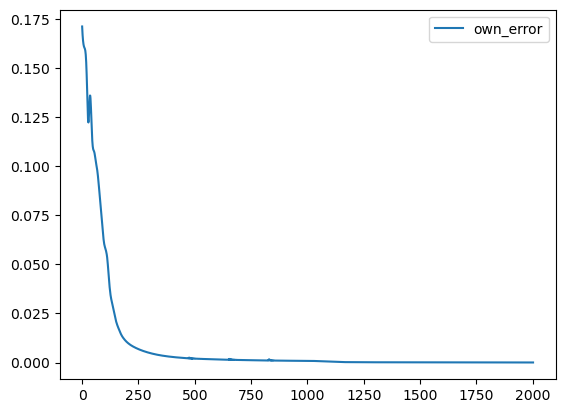

In [ ]:
fig, ax = plt.subplots()
x_net = np.arange(0,net.iter,1)
x_pinns = np.arange(0,net_pinns.iter,1)
ax.plot(x_net,error_own, label='own_error')
#ax.plot(x_pinns,error_pinns, label = 'pinns_error')
ax.legend()

In [20]:
np.savetxt('error_pinns.txt', error_pinns)
b = np.loadtxt('error_pinns.txt')
error_pinns == b

array([ True,  True,  True, ...,  True,  True,  True])

In [22]:
b.size

1046

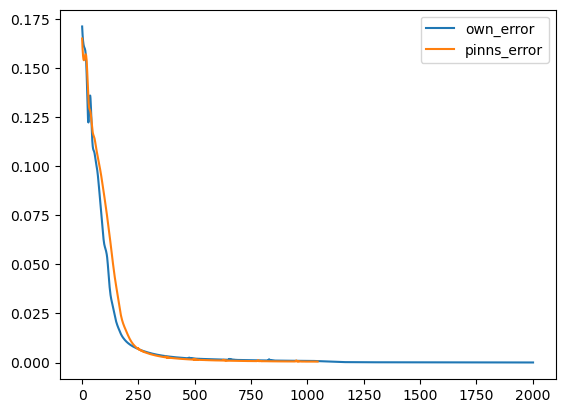

In [23]:
error_own = np.loadtxt('error_owm.txt')

fig, ax = plt.subplots()
x_net = np.arange(0,error_own.size,1)
x_pinns = np.arange(0,net_pinns.iter,1)
ax.plot(x_net,error_own, label='own_error')
ax.plot(x_pinns,error_pinns, label = 'pinns_error')
ax.legend()

# Evaluate
- 构造测试集
- evalua

In [ ]:
x_test = np.arange(0,np.pi,0.14)
t = np.arange(0,10,0.6)
x_test_tensor = torch.from_numpy(x_test).unsqueeze(1)
t_tensor = torch.from_numpy(t).unsqueeze(1)

In [ ]:
print(t_tensor.size(),x_test_tensor.size())

torch.Size([17, 1]) torch.Size([23, 1])


In [ ]:
xt_x_test_tensor = x_test_tensor.detach()
xt_t_tensor = t_tensor.detach()
print(xt_x_test_tensor.size(),xt_t_tensor.size())
for i in range(16):
    xt_x_test_tensor = torch.cat((xt_x_test_tensor,x_test_tensor),0)
for i in range(22):
    xt_t_tensor = torch.cat((xt_t_tensor,t_tensor),0)
print(xt_t_tensor.size(),xt_x_test_tensor.size())
xt_test_tensor = torch.cat((xt_x_test_tensor,xt_t_tensor),1)
xt_test_tensor = xt_test_tensor.to("cuda").to(torch.float32)
print(xt_test_tensor.size())

torch.Size([23, 1]) torch.Size([17, 1])
torch.Size([391, 1]) torch.Size([391, 1])
torch.Size([391, 2])


In [ ]:
net.eval_()
net_testvalue = net.model(xt_test_tensor)
net_pinns.eval_()
net_pinns_testvalue = net_pinns.model(xt_test_tensor)
print(net_testvalue.size(),net_pinns_testvalue.size())

torch.Size([391, 1]) torch.Size([391, 1])


In [ ]:
print(net.model(torch.tensor([3.,7.]).to("cuda")))
print(net_pinns.model(torch.tensor([3.,7.]).to("cuda")))
print(torch.sin(torch.tensor(3.))*torch.exp(torch.tensor(-7.)))

tensor([0.0032], device='cuda:0', grad_fn=<AddBackward0>)
tensor([-0.0012], device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001)


In [ ]:
print(net.model(torch.tensor([1.,8.]).to("cuda")))
print(net_pinns.model(torch.tensor([1.,8.]).to("cuda")))
print(torch.sin(torch.tensor(3.))*torch.exp(torch.tensor(-7.)))

tensor([0.0045], device='cuda:0', grad_fn=<AddBackward0>)
tensor([-0.0028], device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001)


In [ ]:
print(net.model(torch.tensor([torch.pi,8.]).to("cuda")))
print(net_pinns.model(torch.tensor([torch.pi,8.]).to("cuda")))
print(torch.sin(torch.tensor(0))*torch.exp(torch.tensor(-7.)))

tensor([0.0004], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0008], device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.)


In [ ]:
print(net.loss,net_pinns.loss)

tensor([1.0400, 0.9991, 0.9605,  ..., 0.0285, 0.0285, 0.0285], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([6.2504e-01, 5.9260e-01, 5.6156e-01,  ..., 1.3618e-04, 1.3618e-04,
        1.3618e-04], device='cuda:0', grad_fn=<CatBackward0>)


In [ ]:
realvalue = torch.sin(xt_test_tensor[:,0])*torch.exp(-xt_test_tensor[:,1])
realvalue = realvalue.unsqueeze(1)
print(realvalue.size())

torch.Size([391, 1])


In [ ]:
L2norm = nn.MSELoss()
net_error = L2norm(realvalue,net_testvalue)
pinns_error = L2norm(realvalue,net_pinns_testvalue)
print(f"net's error{net_error}")
print(f"pinns's error{pinns_error}")

net's error0.0010369246592745185
pinns's error8.646208698337432e-06


In [ ]:
net_xt = xt_test_tensor.detach().to("cuda")
pinns_xt = xt_test_tensor.detach().to("cuda")
net_xt.requires_grad_()
pinns_xt.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.1400, 0.6000],
        [0.2800, 1.2000],
        [0.4200, 1.8000],
        [0.5600, 2.4000],
        [0.7000, 3.0000],
        [0.8400, 3.6000],
        [0.9800, 4.2000],
        [1.1200, 4.8000],
        [1.2600, 5.4000],
        [1.4000, 6.0000],
        [1.5400, 6.6000],
        [1.6800, 7.2000],
        [1.8200, 7.8000],
        [1.9600, 8.4000],
        [2.1000, 9.0000],
        [2.2400, 9.6000],
        [2.3800, 0.0000],
        [2.5200, 0.6000],
        [2.6600, 1.2000],
        [2.8000, 1.8000],
        [2.9400, 2.4000],
        [3.0800, 3.0000],
        [0.0000, 3.6000],
        [0.1400, 4.2000],
        [0.2800, 4.8000],
        [0.4200, 5.4000],
        [0.5600, 6.0000],
        [0.7000, 6.6000],
        [0.8400, 7.2000],
        [0.9800, 7.8000],
        [1.1200, 8.4000],
        [1.2600, 9.0000],
        [1.4000, 9.6000],
        [1.5400, 0.0000],
        [1.6800, 0.6000],
        [1.8200, 1.2000],
        [1.9600, 1.8000],
        [2.1

In [ ]:
net_dx = torch.autograd.grad(inputs=net_xt, outputs=net.model(net_xt),
                                                 grad_outputs=torch.ones_like(net.model(net_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
net_dt = torch.autograd.grad(inputs=net_xt, outputs=net.model(net_xt),
                                                 grad_outputs=torch.ones_like(net.model(net_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
net_dxdx = torch.autograd.grad(inputs=net_xt, outputs=net_dx,
                                                 grad_outputs=torch.ones_like(net_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

In [ ]:
pinns_dx = torch.autograd.grad(inputs=pinns_xt, outputs=net_pinns.model(pinns_xt),
                                                 grad_outputs=torch.ones_like(net_pinns.model(pinns_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
pinns_dt = torch.autograd.grad(inputs=pinns_xt, outputs=net_pinns.model(pinns_xt),
                                                 grad_outputs=torch.ones_like(net_pinns.model(pinns_xt)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
pinns_dxdx = torch.autograd.grad(inputs=pinns_xt, outputs=pinns_dx,
                                                 grad_outputs=torch.ones_like(pinns_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

In [ ]:
realvalue_dt = -realvalue.detach().to("cuda")
realvalue_dxdx = -realvalue.detach().to("cuda")
realvalue_dx = (torch.cos(xt_test_tensor[:,0])*torch.exp(-xt_test_tensor[:,1])).unsqueeze(1)
print(realvalue_dx.size())

torch.Size([391, 1])


In [ ]:
net_w21norm = net_error+L2norm(realvalue_dt,net_dt)+L2norm(realvalue_dx,net_dx)+L2norm(realvalue_dxdx,net_dxdx)
pinns_w21norm = pinns_error+L2norm(realvalue_dt,pinns_dt)+L2norm(realvalue,pinns_dx)+L2norm(realvalue_dxdx,pinns_dxdx)
print(f"net_w21norm's error {net_w21norm}")
print(f"pinns_w21norm's error {pinns_w21norm}")

net_w21norm's error 0.013968365266919136
pinns_w21norm's error 0.0841560959815979


In [ ]:
testx = torch.tensor([1.,2.],requires_grad=True,device="cuda")
net.model(testx)

tensor([0.0740], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
testdx = torch.autograd.grad(inputs=testx, outputs=net.model(testx),
                                                 grad_outputs=torch.ones_like(net.model(testx)),
                                                 retain_graph=True,
                                                 create_graph=True)
print(testdx)

(tensor([ 0.0306, -0.0738], device='cuda:0', grad_fn=<SqueezeBackward1>),)


# Plot
